In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
print ('number of GPUs:', torch.cuda.device_count())

from tqdm import tqdm
from matplotlib import pyplot as plt 

from minichatgpt.experiments.imdb import config, sent_kwargs
from minichatgpt import Lab
from minichatgpt.processdata.collators import imdb_dataloader_collator

# For the sake of the speed of this demonstration, the batch_size is temporarily decreased from 256 to 4
batch_size = 64
config.batch_size = batch_size
config.forward_batch_size = batch_size//2
config.seed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
number of GPUs: 2


0

In [42]:
lab = Lab(config)

dataset = lab.build_dataset(dataset_name="imdb",input_min_text_length=2,input_max_text_length=8)

new_policy, old_policy, tokenizer = lab.init_policies_tokenizer()

lab.set_generation_config(do_sample=True,output_min_length=4,output_max_length=16,pad_token_id=tokenizer.eos_token_id)

ppo_trainer = lab.init_ppo_trainer(
    config, 
    new_policy, 
    old_policy, 
    tokenizer, 
    dataset, 
    dataloader_collator = imdb_dataloader_collator,
)

reward_model = lab.init_reward_model()

Found cached dataset imdb (/home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a680d0720b68191d.arrow
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ec21da66149d9ccd.arrow


In [34]:
returns_list = []
print(new_policy.pretrained_model.device)
print(new_policy.v_head)
new_policy.v_head.summary.to('cuda:1')
print(new_policy.v_head.summary.weight.device)

cuda:0
ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
cuda:1


In [35]:
new_policy.pretrained_model.parallelize()

In [44]:
lab.reward_model.device

device(type='cuda', index=0)

In [ ]:
for batch_step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    
    queries = batch['input_ids']
    
    #### Get response from gpt2
    responses = []
    for query in queries:
        gen_len = lab.output_length_sampler()
        lab.generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **lab.generation_kwargs)
        responses.append(response.squeeze()[-gen_len:])
        
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in responses]
    
    #### Compute sentiment score
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = lab.reward_model(texts, **sent_kwargs)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]
    
    rewards = [t.to(new_policy.pretrained_model.device) for t in rewards]
    
    #### Run PPO step 
    stats = ppo_trainer.step(queries, responses, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
    
    #break
    
    returns_list.append(stats['ppo/returns/mean'])

0it [00:00, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
1it [00:19, 19.93s/it]

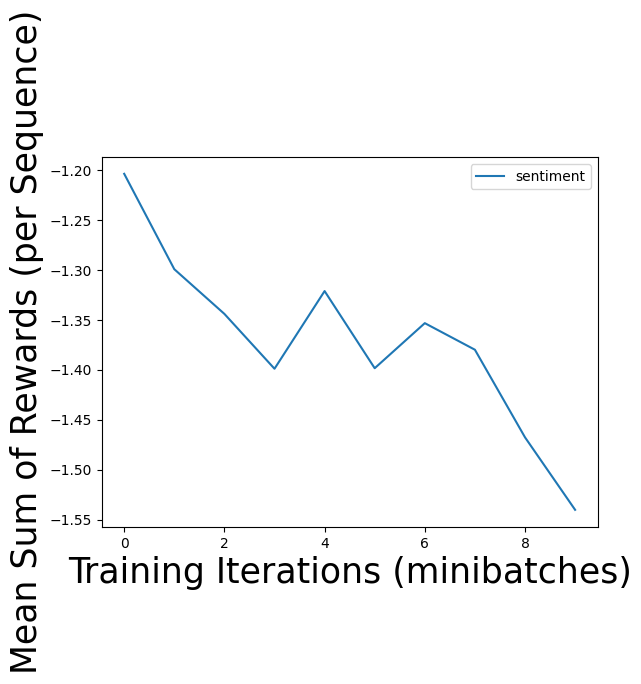

In [28]:
plt.figure()
plt.xlabel('Training Iterations (minibatches)', fontsize=25)
plt.ylabel('Mean Sum of Rewards (per Sequence)', fontsize=25)
plt.plot(returns_list, label='sentiment')
plt.legend()
plt.show()